In [1]:
%matplotlib inline

In [2]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.learning_curve import learning_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn import cluster
from sklearn import preprocessing

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [3]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [4]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])

### Cleanup Data - Date, FillNaN etc

In [5]:
def date_to_julian_day(row):
    """Returns the Julian day number of a date."""
    date_format = '%m/%d%Y'
    recorded_date = row['date']
    a = (14 - recorded_date.month)//12
    y = recorded_date.year + 4800 - a
    m = recorded_date.month + 12*a - 3
    return (recorded_date.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 320450)**0.5

In [6]:
people['julian'] = people.apply(date_to_julian_day, axis=1)
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)
        
        
people_cols = [col for col in people.columns if col not in ['people_id', 'year', 'month', 'day']]
Xp = people[people_cols]
Xp = preprocessing.StandardScaler().fit_transform(Xp)

In [ ]:
km = cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, 
                     tol=0.0001, precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1)
featurecomponents = km.fit_transform(Xp)

#print(pca.explained_variance_ratio_)
p1 = people.as_matrix(columns=['people_id'])
combined = np.hstack([p1, featurecomponents])
people = pd.DataFrame(data=combined, columns=['people_id', 'km1', 'km2'])  

In [9]:
people.head()

,people_id,km1,km2
0,ppl_100,7.68439,7.7471
1,ppl_100002,7.51952,8.59639
2,ppl_100003,5.31346,10.6793
3,ppl_100004,5.17491,11.6547
4,ppl_100006,9.31906,4.93931


In [ ]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['julian'] = table.apply(date_to_julian_day, axis=1)
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

### Select Features for Model

In [11]:
feature_cols = [col for col in train.columns if col not in ['people_id', 'activity_id','outcome', 'day', 'month', 'year']]
target = 'outcome'

In [12]:
print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(feature_cols), sorted(feature_cols)))


Length of train:  2197291
Length of test:  498687
Features [14]: ['activity_category', 'char_1', 'char_10', 'char_2', 'char_3', 'char_4', 'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'julian', 'km1', 'km2']


### Function to Model ROC

In [13]:
def plot_roc(model, title):
    model.fit(X_train, y_train)
    actuals = y_train
    predictions  = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(actuals, predictions)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    actuals_t = y_test
    predictions_t  = model.predict(X_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(actuals_t, predictions_t)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, 'r', label='Training = %0.2f'% roc_auc)
    plt.plot(false_positive_rate_t, true_positive_rate_t, 'g', label='Test = %0.2f'% roc_auc_t)
    plt.fill(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.5, )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict=font)
    plt.ylabel('True Positive Rate', fontdict=font)
    title = "Redhat Dataset " + title
    plt.title(title, fontdict=font)
    plt.legend(loc="lower right", fontsize=20)
    #plt.savefig(name, bbox_inches='tight')
    plt.show()
    return roc_auc 

In [14]:
def plot_learning_curve(estimator, title, ylim=None):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    cv=None
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    title = "RedHat Dataset - " + title
    plt.title(title, y=1.08, fontdict=font)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontdict=font)
    plt.ylabel("Score", fontdict=font)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation score")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [15]:
def models(clf):
    start = time.time()
    print(clf)
    print("")
    clf.fit(X_train, y_train)
    # summarize the fit of the model
    expected = y_test
    predicted = clf.predict(X_test)
    
    # summarize the fit of the model
    score = clf.score(X_test, y_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(expected, predicted)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)
    
    print("ROC_AUC score using test set: {}\n".format(str(roc_auc_t)))
    print("="*66)
    print("")
    # train the model with whole training dataset now
    clf.fit(X, y)
    # make predictions
    expected = y
    predicted = clf.predict(X)
    # print confusion matrix
    cm = metrics.confusion_matrix(expected, predicted)
    target_names = ['bad', 'good']
    fig, ax = plt.subplots()
    sns_cm = sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names , ax=ax)
    title = "RedHat Training Dataset - Confusion Matrix"
    ax.set_title(title, y=1.08, fontdict=font)
    fig.show()
    end = time.time()
    total = end-start
    minutes = total//60.0
    seconds = total%60.0
    print("Total running time for this model = {} seconds ({} minutes {} seconds)".format(total, minutes, seconds))
    print("")
    return

In [16]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 14)
(1757832,)


### Random Forest & XgBoost Model

In [18]:
model = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

ROC_AUC score using test set: 0.947923398623


Total running time for this model = 228.7801570892334 seconds (3.0 minutes 48.7801570892334 seconds)



/usr/local/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


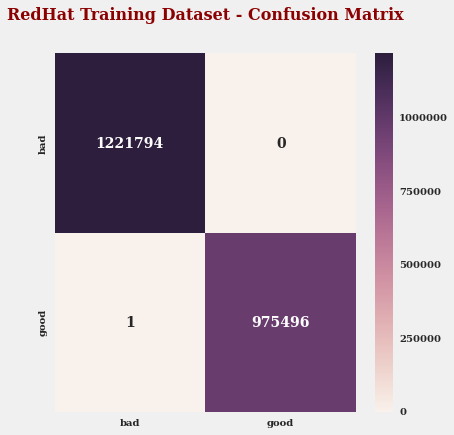

In [19]:
models(model)

In [20]:
scores = cross_validation.cross_val_score(model, X, y, n_jobs=-1, scoring="roc_auc", cv=5)
print(scores)
print("")
print(sum(scores)/len(scores))

[ 0.84920707  0.81838064  0.85180838  0.83179176  0.80447376]

0.831132321373


In [21]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_cols), 
             reverse=True))
ft = (sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_cols), 
             reverse=True))[:10]
print("")
important_features = [x[1] for x in ft]
print(important_features)

Features sorted by their score:
[(0.42509999999999998, 'km2'), (0.375, 'km1'), (0.1075, 'julian'), (0.064399999999999999, 'char_10'), (0.0141, 'activity_category'), (0.0020999999999999999, 'char_9'), (0.0020999999999999999, 'char_1'), (0.002, 'char_2'), (0.0016999999999999999, 'char_3'), (0.0015, 'char_8'), (0.0014, 'char_7'), (0.0011999999999999999, 'char_5'), (0.001, 'char_6'), (0.00089999999999999998, 'char_4')]

['km2', 'km1', 'julian', 'char_10', 'activity_category', 'char_9', 'char_1', 'char_2', 'char_3', 'char_8']


In [31]:
important_features = ['km2', 'km1', 'julian', 'char_10']
X = train[important_features]
Xt = test[important_features]
y = train['outcome']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 4)
(1757832,)


In [30]:
scores = cross_validation.cross_val_score(model, X, y, n_jobs=-1, scoring="roc_auc", cv=5)
print(scores)
print("")
print(sum(scores)/len(scores))

[ 0.74032754  0.72294499  0.75984826  0.73308125  0.70679807]

0.732600020196


In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_test1.shape)
print(y_test1.shape)

In [16]:
model = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0,
            warm_start=False)
model2 = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [17]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [18]:
model2.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [19]:
model_vc = ensemble.VotingClassifier(estimators= [('rf', model), ('xgb', model2)], voting='hard')

In [20]:
model_vc.fit(X,y)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
        ...gistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))],
         voting='hard', weights=None)

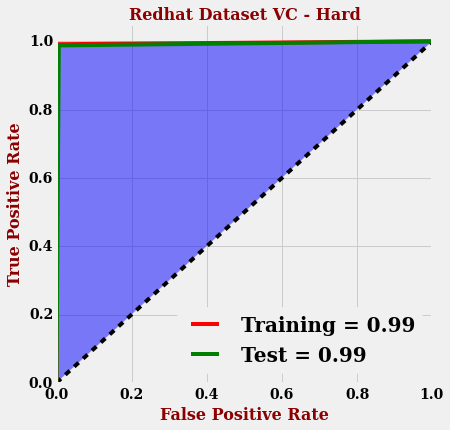

0.99462510032795048

In [21]:
plot_roc(model_vc, "VC - Hard")

In [22]:
y_predict = model.predict_proba(Xt)

In [23]:
yPred = y_predict[:,1]

In [24]:
current_time = datetime.datetime.now()

In [25]:
sub = pd.DataFrame()
sub['activity_id'] = test['activity_id']
sub['outcome'] = yPred.tolist()
sub.to_csv('submission_vc_hard_' + str(current_time.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)